# Mini Project
Thinakone Louangdy

This is the three websites that I pick to perform an EDA in this project

In [ ]:
# Source
# Momondo: https://www.momondo.com/flight-search/HEL-VIE,SZG,INN/2023-11-23?sort=bestflight_a
# Kayak: https://www.kayak.com/flights/HEL-VIE,nearby/2023-11-23?sort=bestflight_a
# Booking.kayak.com: https://booking.kayak.com/flights/HEL-VIE/2023-11-23?sort=bestflight_a

# Install driver and libraries for our Colab environment

In [1]:
!apt update
!apt install chromium-chromedriver
!pip install selenium
!pip install selenium-stealth
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb && apt install ./google-chrome-stable_current_amd64.deb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [518 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,223 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,247 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,078 kB]
Get:13 

# Set up driver and import libraries to use for scraping the data from websites

In [2]:
from time import sleep
from selenium_stealth import stealth
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import re
import csv
import pandas as pd

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument("lang=en")
options.add_argument("start-maximized")
options.add_argument("disable-infobars")
options.add_argument("--disable-extensions")
options.add_argument("--incognito")
options.add_argument("--disable-blink-features=AutomationControlled")

driver = webdriver.Chrome(options=options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )

# Create functions for scraping the data

In [3]:
def press_button_pagination(driver, btn_class_name):
    while True:
        try:
            more_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, btn_class_name)))
            more_button.click()
            WebDriverWait(driver, 30)
        except Exception as e:
            print(str(e))
            break

def text_elements(elements, selector, element="span"):
    el = elements.find(element, selector)

    if el is not None:
        return el.text
    else:
        return None

def transit_details(transits):
    for elements in transits:
        departList = elements.find_all("div", "col-field time depart")
        departLocation = text_elements(departList[0], "bottom", "div")
        arrivalList = elements.find_all("div", "col-field time return")
        arrivalLocation = text_elements(arrivalList[0], "bottom", "div")
        transitLocation = None
        airportName = None
        layoverTime = None

        if departLocation == "HEL":
            flight_stop = elements.find("div", "bottom stops").text
            directFlight = flight_stop == "\nnonstop "

            if directFlight == False:
                transitLocation = text_elements(elements, "js-layover")
                transitInfo = elements.find("span", "js-layover")["title"]
                transitTime = transitInfo.split("layover,")
                layoverTime = transitTime[0]
                pattern = r"<b>(.*?)</b>"
                match = re.findall(pattern, transitInfo)
                airportName = match[0]

            depart_time = text_elements(elements, "depart-time base-time")
            arrival_time = text_elements(elements, "arrival-time base-time")
            duration_div = elements.find("div", "col-field duration")
            flight_duration = duration_div.find("div", "top").text

            return (
                "HEL",
                arrivalLocation,
                directFlight,
                transitLocation,
                layoverTime,
                airportName,
                depart_time,
                arrival_time,
                flight_duration,
            )


def findTransitDetail(transits):
    flight = transits[0]
    flight_time = flight.find("div", "vmXl vmXl-mod-variant-large")
    flight_time_spans = flight_time.find_all("span")
    departure_time, arrival_time = flight_time_spans[0].text, flight_time_spans[2].text
    airport_names = flight.find_all("span", "EFvI-ap-info")
    depart_location, arrival_location = airport_names[0].text, airport_names[1].text
    stop_div = flight.find("div", "JWEO")
    stop_text = stop_div.find("span", "JWEO-stops-text").text
    airport_name = None
    transit_location = None
    layover_time = None
    multiple_stops = None
    flight_duration = flight.find_all("div", "vmXl vmXl-mod-variant-default")[1].text

    if stop_text != "nonstop":
        multiple_stops = True
    else:
        multiple_stops = False

    if multiple_stops:
        stop = stop_div.find("div", "c_cgF c_cgF-mod-variant-default")
        span_element = stop.find_all("span")
        pattern = r"<b>(.*?)</b>"

        if len(span_element) > 0:
            match = re.findall(pattern, span_element[1]["title"])
            airport_name = match[0]
            transit_location = span_element[1].text
            layover_time = span_element[1]["title"].split(" layover,")[0]

    return ( depart_location,
            arrival_location,
             not multiple_stops,
             transit_location,
             layover_time,
             airport_name,
             departure_time,
             arrival_time,
             flight_duration )

#Kayak & Momondo
def scrapeFlights(driver, url, website_name):
    driver.get(url)
    for _ in range(10):
        try:
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")))
            press_button_pagination(driver, "div.resultsPaginator div.show-more-button")
        except Exception as e:
            if (e == 'TimeoutException') :
                continue

    webpage = driver.page_source

    webPageSource = BeautifulSoup(webpage, 'html.parser')
    allFlights = webPageSource.find_all("div", class_="nrc6")
    flight_list = []

    for flight in allFlights:
        transitFlight = flight.find_all("li", "hJSA-item")
        flightDetail = findTransitDetail(transitFlight)
        airlinesList = flight.find_all("div", class_="VY2U")
        price = flight.find("div", "f8F1-price-text").text
        airlineName = None

        if len(airlinesList) != 0:
            airlines = airlinesList[0].find("div", class_="c_cgF c_cgF-mod-variant-default")
            if airlines:
                airlineName = airlines.text
        flightData = {
            "airlines": airlineName,
            "depart_time": flightDetail[6],
            "arrival_time": flightDetail[7],
            "depart_location": flightDetail[0],
            "destination": flightDetail[1],
            "duration": flightDetail[-1],
            "direct": flightDetail[2],
            "layover": flightDetail[4],
            "transit_location": flightDetail[3],
            "transit_airport": flightDetail[5],
            "price": price,
            "website": website_name
            }
        flight_list.append(flightData)
    return flight_list

# Booking
def BookingFlights(driver, url):
    driver.get(url)
    for _ in range(10):
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.resultsPaginator")))
        press_button_pagination(driver, "div.resultsPaginator")

    webpage = driver.page_source

    webSource = BeautifulSoup(webpage, 'html.parser')
    flights = webSource.find_all(class_="inner-grid keel-grid")
    flight_list = []

    for flight in flights:
        transitInfo = flight.find_all("li", "flight")
        flightInfo = transit_details(transitInfo)
        airlines_div_tag = flight.find("div", "col-field carrier")

        if airlines_div_tag is not None:
            airline_name = text_elements(airlines_div_tag, "bottom", "div")
            dropdown = flight.find_all("div", "multibook-dropdown")
            price = text_elements(dropdown[0], "price-text", "span")
            source = text_elements(dropdown[0], "name-only-text", "span")

            flightData = {
                "airlines":  airline_name,
                "depart_time": flightInfo[6],
                "arrival_time": flightInfo[7],
                "depart_location": flightInfo[0],
                "destination": flightInfo[1],
                "duration": flightInfo[-1],
                "direct": flightInfo[2],
                "layover": flightInfo[4],
                "transit_location": flightInfo[3],
                "transit_airport": flightInfo[5],
                "price": price.split('\n')[1],
                "website": "Booking.com"
            }

            flight_list.append(flightData)
    return flight_list


# Scrape data from Kayak

In [4]:
kayakFlight = scrapeFlights(driver, 'https://www.kayak.com/flights/HEL-VIE/2023-11-23?sort=bestflight_a', website_name='Kayak')
print(len(kayakFlight))
# print(kayakFlight)

Message: element click intercepted: Element <div role="button" tabindex="0" class="ULvh-button show-more-button">...</div> is not clickable at point (422, 24). Other element would receive the click: <div role="button" tabindex="0" class="NITa NITa-location-inline NITa-hasValue NITa-mod-multi-values">...</div>
  (Session info: headless chrome=117.0.5938.132)
Stacktrace:
#0 0x56378a3326b3 <unknown>
#1 0x56378a0081e7 <unknown>
#2 0x56378a05565d <unknown>
#3 0x56378a0539fd <unknown>
#4 0x56378a0517b8 <unknown>
#5 0x56378a050827 <unknown>
#6 0x56378a0454f9 <unknown>
#7 0x56378a0710c2 <unknown>
#8 0x56378a044f16 <unknown>
#9 0x56378a07128e <unknown>
#10 0x56378a08a322 <unknown>
#11 0x56378a070e93 <unknown>
#12 0x56378a043934 <unknown>
#13 0x56378a04471e <unknown>
#14 0x56378a2f7cb8 <unknown>
#15 0x56378a2fbbf0 <unknown>
#16 0x56378a30619c <unknown>
#17 0x56378a2fc808 <unknown>
#18 0x56378a2c927f <unknown>
#19 0x56378a320e88 <unknown>
#20 0x56378a321059 <unknown>
#21 0x56378a331843 <unknown>


# Scrape data from Momondo

In [5]:
momondoFlight = scrapeFlights(driver, 'https://www.momondo.com/flight-search/HEL-VIE/2023-11-23?sort=bestflight_a', website_name='Momondo')
print(len(momondoFlight))
# print(momondoFlight)

Message: element click intercepted: Element <div role="button" tabindex="0" class="ULvh-button show-more-button">...</div> is not clickable at point (422, 24). Other element would receive the click: <div role="button" tabindex="0" class="NITa NITa-location-inline NITa-hasValue NITa-mod-multi-values">...</div>
  (Session info: headless chrome=117.0.5938.132)
Stacktrace:
#0 0x56378a3326b3 <unknown>
#1 0x56378a0081e7 <unknown>
#2 0x56378a05565d <unknown>
#3 0x56378a0539fd <unknown>
#4 0x56378a0517b8 <unknown>
#5 0x56378a050827 <unknown>
#6 0x56378a0454f9 <unknown>
#7 0x56378a0710c2 <unknown>
#8 0x56378a044f16 <unknown>
#9 0x56378a07128e <unknown>
#10 0x56378a08a322 <unknown>
#11 0x56378a070e93 <unknown>
#12 0x56378a043934 <unknown>
#13 0x56378a04471e <unknown>
#14 0x56378a2f7cb8 <unknown>
#15 0x56378a2fbbf0 <unknown>
#16 0x56378a30619c <unknown>
#17 0x56378a2fc808 <unknown>
#18 0x56378a2c927f <unknown>
#19 0x56378a320e88 <unknown>
#20 0x56378a321059 <unknown>
#21 0x56378a331843 <unknown>


# Scrape data from Booking.kayak

In [8]:
bookingFlight = BookingFlights(driver, 'https://booking.kayak.com/flights/HEL-VIE/2023-11-23?sort=bestflight_a')
print(len(bookingFlight))
# print(bookingFlight)

Message: element not interactable: element has zero size
  (Session info: headless chrome=117.0.5938.132)
Stacktrace:
#0 0x56378a3326b3 <unknown>
#1 0x56378a0081e7 <unknown>
#2 0x56378a0507bd <unknown>
#3 0x56378a0454f9 <unknown>
#4 0x56378a0710c2 <unknown>
#5 0x56378a044f16 <unknown>
#6 0x56378a07128e <unknown>
#7 0x56378a08a322 <unknown>
#8 0x56378a070e93 <unknown>
#9 0x56378a043934 <unknown>
#10 0x56378a04471e <unknown>
#11 0x56378a2f7cb8 <unknown>
#12 0x56378a2fbbf0 <unknown>
#13 0x56378a30619c <unknown>
#14 0x56378a2fc808 <unknown>
#15 0x56378a2c927f <unknown>
#16 0x56378a320e88 <unknown>
#17 0x56378a321059 <unknown>
#18 0x56378a331843 <unknown>
#19 0x7b88d73cbb43 <unknown>

Message: element not interactable: element has zero size
  (Session info: headless chrome=117.0.5938.132)
Stacktrace:
#0 0x56378a3326b3 <unknown>
#1 0x56378a0081e7 <unknown>
#2 0x56378a0507bd <unknown>
#3 0x56378a0454f9 <unknown>
#4 0x56378a0710c2 <unknown>
#5 0x56378a044f16 <unknown>
#6 0x56378a07128e <unknow

# Save the data from our scraping as a csv file format for further visualization

In [9]:
# Save in CSV
zipped = kayakFlight + momondoFlight + bookingFlight
df = pd.DataFrame(zipped)
df.to_csv('Flights.csv', index=False, header=[
    'Airlines',
    'Depart Time',
    'Arrival Time',
    'Departure Location',
    'Destination',
    'Flight Duration',
    'Direct Flight',
    'Layover Time',
    'Transit Location',
    'Transit Airport',
    'Price',
    'Website'
    ])

# Load data to perform EDA

In [10]:
#  Load data
data = pd.read_csv('Flights.csv')
data

,Airlines,Depart Time,Arrival Time,Departure Location,Destination,Flight Duration,Direct Flight,Layover Time,Transit Location,Transit Airport,Price,Website
0,Finnair,9:25 am,10:55 am,HEL,VIE,2h 30m,True,NaN,NaN,NaN,$117,Kayak
1,Ryanair,10:45 am,6:25 pm,HEL,VIE,8h 40m,False,4h 00m,BGY,Bergamo Orio Al Serio,$82,Kayak
2,Finnair,5:00 pm,6:30 pm,HEL,VIE,2h 30m,True,NaN,NaN,NaN,$138,Kayak
3,airBaltic,3:30 pm,6:40 pm,HEL,VIE,4h 10m,False,1h 10m,RIX,Riga Intl,$83,Kayak
4,airBaltic,5:20 am,8:25 am,HEL,VIE,4h 05m,False,1h 05m,RIX,Riga Intl,$103,Kayak
...,...,...,...,...,...,...,...,...,...,...,...,...
443,British Airways,7:50,5:50,HEL,VIE,11h 00m,False,5h 20m,LHR,London Heathrow,$473,Booking.com
444,British Airways,7:50,1:25,HEL,VIE,6h 35m,False,1h,LHR,London Heathrow,$712,Booking.com
445,Scandinavian Airlines,7:25,5:40,HEL,VIE,11h 15m,False,2h 05m,ARN,Stockholm Arlanda,$511,Booking.com
446,British Airways,7:50,4:05,HEL,VIE,9h 15m,False,3h 40m,LHR,London Heathrow,$627,Booking.com



# Check and remove unwanted data

In [11]:
# Check unwanted data
data[data.Airlines == 'Undisclosed Carrier']

,Airlines,Depart Time,Arrival Time,Departure Location,Destination,Flight Duration,Direct Flight,Layover Time,Transit Location,Transit Airport,Price,Website
147,Undisclosed Carrier,3pm-4pm,3pm,HEL,VIE,4h 10m,False,NaN,NaN,NaN,$204,Momondo
148,Undisclosed Carrier,6pm-7pm,6pm,HEL,VIE,4h 30m,False,NaN,NaN,NaN,$247,Momondo
154,Undisclosed Carrier,7am-8am,7am,HEL,VIE,5h 40m,False,NaN,NaN,NaN,$212,Momondo
158,Undisclosed Carrier,1pm-2pm,1pm,HEL,VIE,5h 05m,False,NaN,NaN,NaN,$274,Momondo
185,Undisclosed Carrier,7am-8am,7am,HEL,VIE,5h 40m,False,NaN,NaN,NaN,$331,Momondo
196,Undisclosed Carrier,5am-6am,5am,HEL,VIE,6h 05m,False,NaN,NaN,NaN,$230,Momondo
208,Undisclosed Carrier,6am-7am,6am,HEL,VIE,6h 05m,False,NaN,NaN,NaN,$367,Momondo
222,Undisclosed Carrier,10am-11am,10am,HEL,VIE,10h 15m,False,NaN,NaN,NaN,$163,Momondo
252,Undisclosed Carrier,8am-9am,8am,HEL,VIE,9h 55m,False,NaN,NaN,NaN,$226,Momondo
285,Undisclosed Carrier,7am-8am,7am,HEL,VIE,10h 35m,False,NaN,NaN,NaN,$376,Momondo


In [12]:
# Drop the rows where the Airlines column is equal to 'Undisclosed Carrier'
data = data.drop(data[data['Airlines'] == 'Undisclosed Carrier'].index)

# Check if it's still there or not
data[data.Airlines == 'Undisclosed Carrier']

,Airlines,Depart Time,Arrival Time,Departure Location,Destination,Flight Duration,Direct Flight,Layover Time,Transit Location,Transit Airport,Price,Website



# Start playing with the data

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  Check the basic information of our data
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 438 entries, 0 to 447
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Airlines            438 non-null    object
 1   Depart Time         438 non-null    object
 2   Arrival Time        438 non-null    object
 3   Departure Location  438 non-null    object
 4   Destination         438 non-null    object
 5   Flight Duration     438 non-null    object
 6   Direct Flight       438 non-null    bool  
 7   Layover Time        434 non-null    object
 8   Transit Location    434 non-null    object
 9   Transit Airport     434 non-null    object
 10  Price               438 non-null    object
 11  Website             438 non-null    object
dtypes: bool(1), object(11)
memory usage: 41.5+ KB



# Check duplicates and drop it

In [19]:
# Check duplicate values
data.duplicated().sum()

1

In [20]:
# Drop duplicated values
data.drop_duplicates(inplace=True)

data.duplicated().sum()

0

# Check null data, but in this case we won't remove or drop it because it is the Direct flight

In [21]:
# Check for missing values
data.isnull().sum()

Airlines              0
Depart Time           0
Arrival Time          0
Departure Location    0
Destination           0
Flight Duration       0
Direct Flight         0
Layover Time          4
Transit Location      4
Transit Airport       4
Price                 0
Website               0
dtype: int64


# Formatting data from csv into a valid numerical for visualization

In [22]:
# Remove $ from price and convert to float
data['Price'] = data['Price'].str.replace('$', '').astype(float)

# Convert time to hours
def convert_time_to_hours(time_string):
    if not isinstance(time_string, str):
        return None

    try:
        hours, minutes = time_string.split('h')
        hours = float(hours)
        minutes = float(minutes.split('m')[0]) / 60
        total_hours = hours + minutes
        return total_hours

    except ValueError:
        return None

flight_duration_hours = []
layover_hours = []

for time_string in data['Layover Time']:
    total_hours = convert_time_to_hours(time_string)
    layover_hours.append(total_hours)

data['Layover Hour'] = layover_hours

for time_string in data['Flight Duration']:
    total_hours = convert_time_to_hours(time_string)
    flight_duration_hours.append(total_hours)

data['Flight Hour'] = flight_duration_hours

# Convert the depart/arrive time column to datetime format and extract the hour component
data['Depart Time'] = pd.to_datetime(data['Depart Time'], errors='coerce')
data['Depart Hour'] = data['Depart Time'].dt.hour

data['Arrival Time'] = data['Arrival Time'].str.lstrip()
data['Arrival Time'] = data['Arrival Time'].str.replace(r'\+\d', '')
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'], errors='coerce')
data['Arrival Hour'] = data['Arrival Time'].dt.hour

<ipython-input-22-e94813e013ad>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Price'] = data['Price'].str.replace('$', '').astype(float)
<ipython-input-22-e94813e013ad>:39: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Arrival Time'] = data['Arrival Time'].str.replace(r'\+\d', '')


In [25]:
data.describe()

,Price,Layover Hour,Flight Hour,Depart Hour,Arrival Hour
count,437.000000,403.000000,437.000000,437.000000,437.000000
mean,255.707094,3.102026,8.406979,9.173913,13.961098
std,113.498560,1.867026,2.186752,4.315213,6.037030
min,82.000000,0.583333,2.500000,1.000000,1.000000
25%,190.000000,1.833333,6.583333,6.000000,9.000000
50%,242.000000,2.583333,8.583333,10.000000,15.000000
75%,295.000000,3.916667,10.166667,12.000000,19.000000
max,761.000000,11.366667,17.766667,23.000000,23.000000



# EDA started from here:

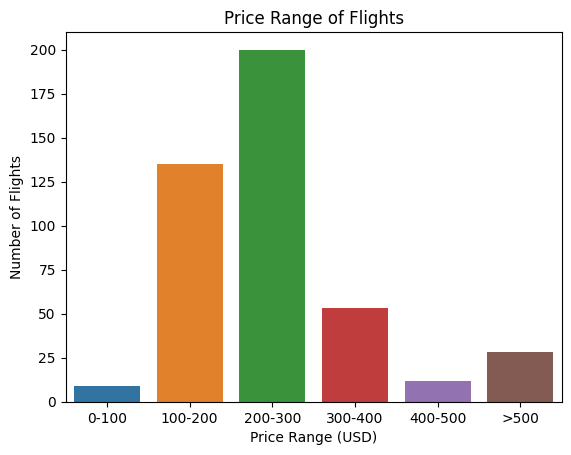

In [27]:
# price ranges
# Showing how many flights belong to each price range
bins = [0, 100, 200, 300, 400, 500, np.inf]
labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '>500']

data['price_range'] = pd.cut(data['Price'], bins=bins, labels=labels)
data['price_range'].value_counts()

sns.countplot(x='price_range', data=data)
plt.xlabel('Price Range (USD)')
plt.ylabel('Number of Flights')
plt.title('Price Range of Flights')
plt.show()

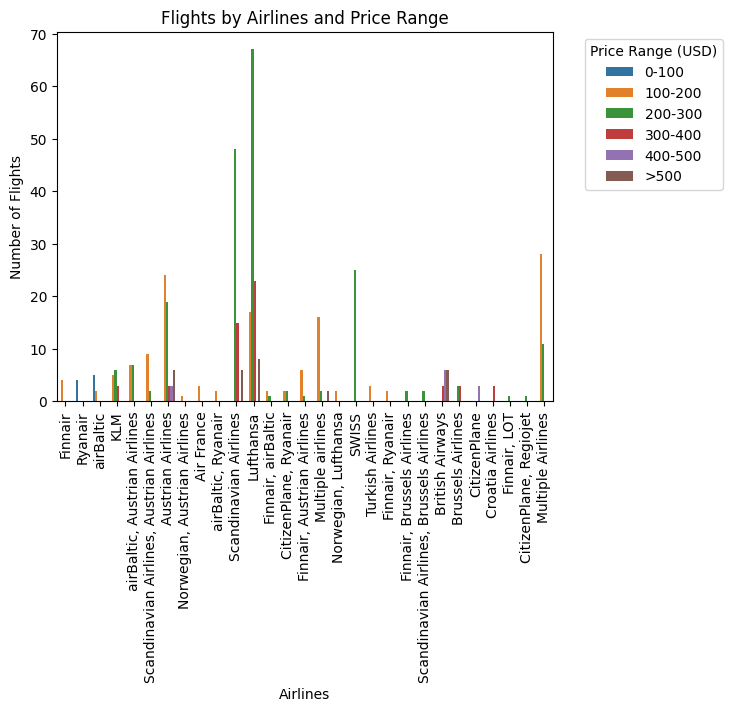

In [28]:
# Airlines
sns.countplot(x='Airlines', hue='price_range', data=data)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel('Airlines')
plt.ylabel('Number of Flights')
plt.title('Flights by Airlines and Price Range')
plt.legend(title='Price Range (USD)', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()



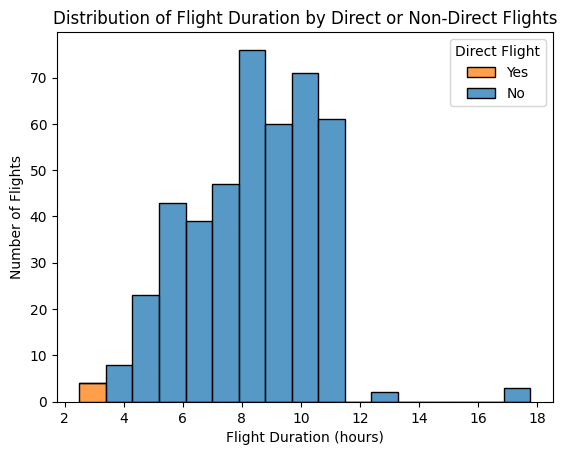

In [29]:
#  What is the distribution of flight duration and how does it vary by direct or non-direct flights?

sns.histplot(x='Flight Hour', hue='Direct Flight', data=data, multiple='stack')
plt.xlabel('Flight Duration (hours)')
plt.ylabel('Number of Flights')
plt.title('Distribution of Flight Duration by Direct or Non-Direct Flights')
plt.legend(title='Direct Flight', labels=['Yes', 'No'])
plt.show()

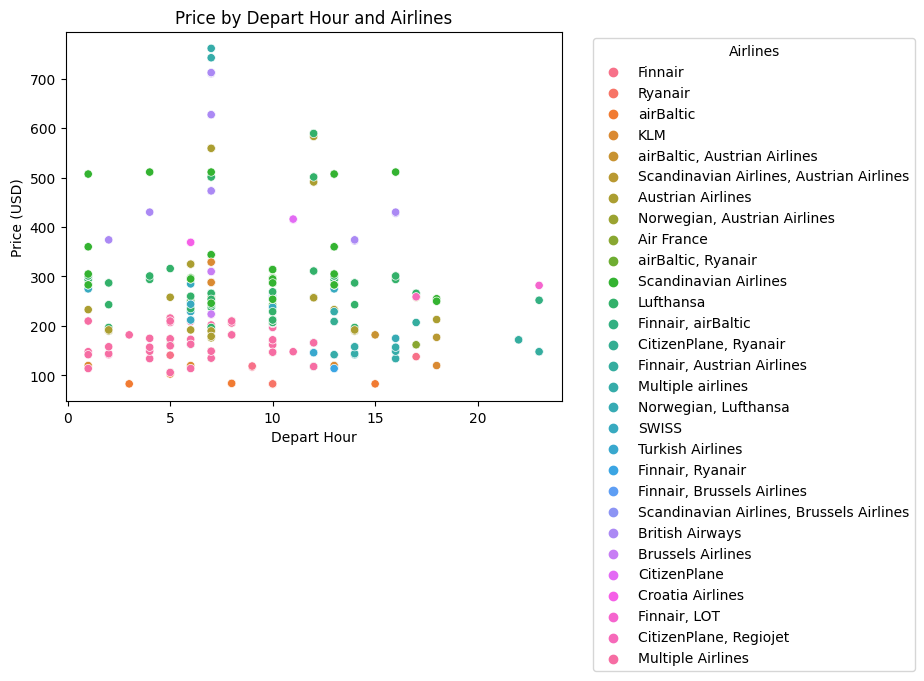

In [30]:
# How does the departure time affect the price of the flights and does it differ by airlines?

sns.scatterplot(x='Depart Hour', y='Price', hue='Airlines', data=data)
plt.xlabel('Depart Hour')
plt.ylabel('Price (USD)')
plt.title('Price by Depart Hour and Airlines')
plt.legend(title='Airlines', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

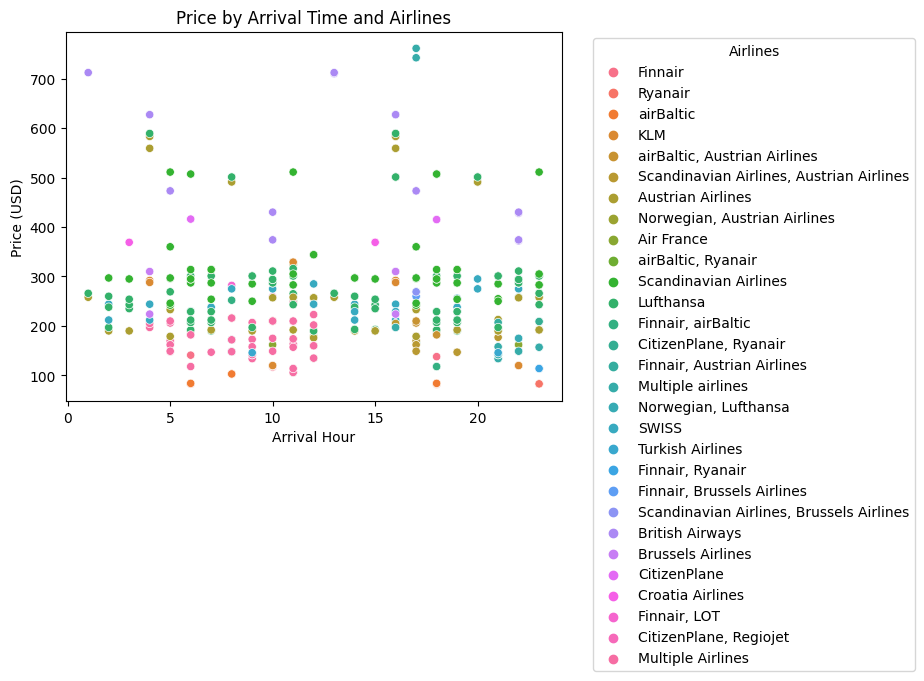

In [32]:
# How does the arrival time affect the price of the flights and does it differ by airlines?

sns.scatterplot(x='Arrival Hour', y='Price', hue='Airlines', data=data)
plt.xlabel('Arrival Hour')
plt.ylabel('Price (USD)')
plt.title('Price by Arrival Time and Airlines')
plt.legend(title='Airlines', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

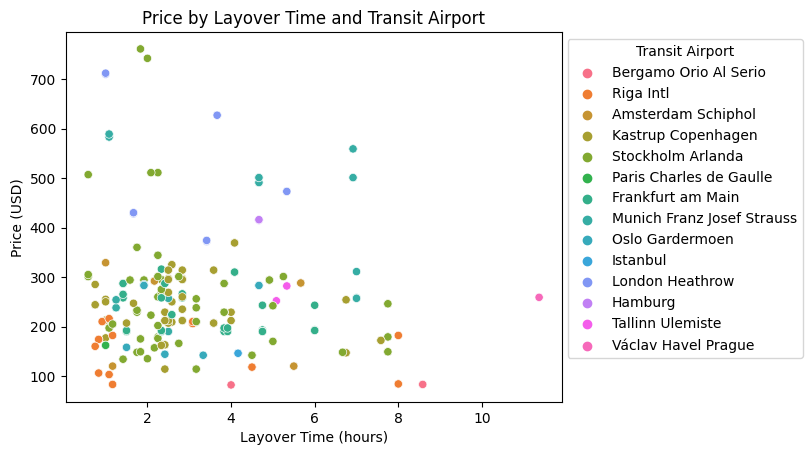

In [33]:
# How does the layover time affect the price of the flights and does it differ by transit location?

sns.scatterplot(x='Layover Hour', y='Price', hue='Transit Airport', data=data)
plt.xlabel('Layover Time (hours)')
plt.ylabel('Price (USD)')
plt.title('Price by Layover Time and Transit Airport')
plt.legend(title='Transit Airport', loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

Text(0, 0.5, 'Price')

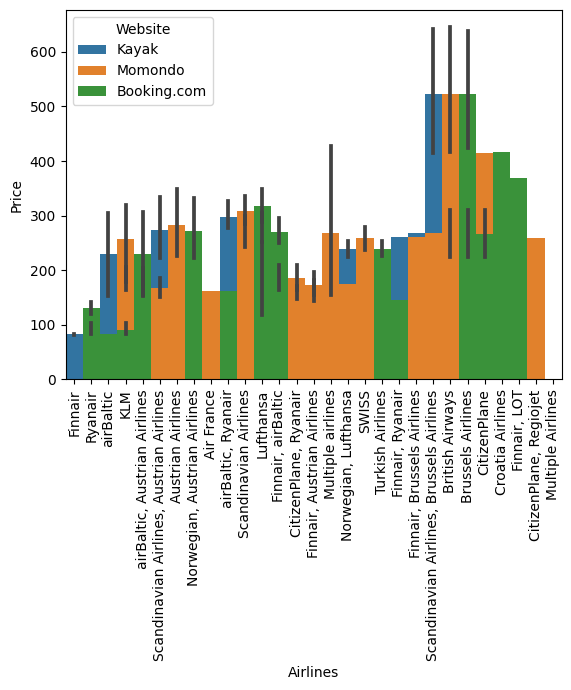

In [34]:
#  Visualize the price by airlines in each website
sns.barplot( x='Airlines', y='Price', hue='Website', data=data, width=3)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel('Airlines')
plt.ylabel('Price')

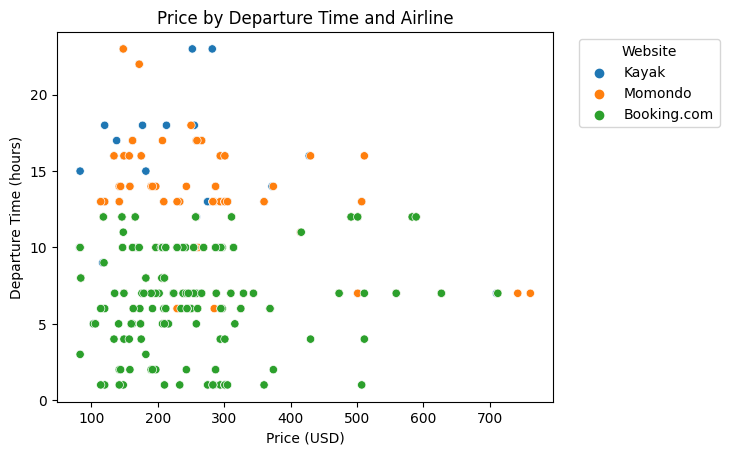

In [38]:
# Departure Time Vs Price | in each sites
sns.scatterplot(x='Price', y='Depart Hour', hue='Website', data=data)
plt.xlabel('Price (USD)')
plt.ylabel('Departure Time (hours)')
plt.title('Price by Departure Time and Airline')
plt.legend(title='Website', loc='upper right', bbox_to_anchor=(1.35, 1))
plt.show()

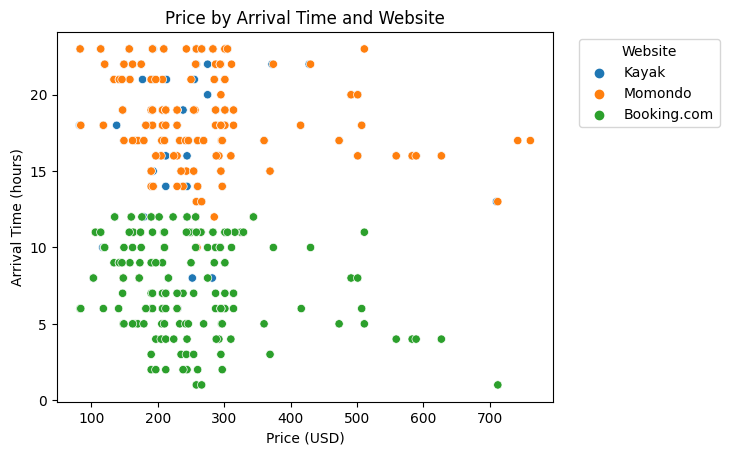

In [37]:
# Arrival Time Vs Price | in each website
sns.scatterplot(x='Price', y='Arrival Hour', hue='Website', data=data)
plt.xlabel('Price (USD)')
plt.ylabel('Arrival Time (hours)')
plt.title('Price by Arrival Time and Website')
plt.legend(title='Website', loc='upper right', bbox_to_anchor=(1.35, 1))
plt.show()

# User Interaction

In [111]:
def flight_filter(data):
    price_min = None
    price_max = None
    duration_min  = None
    duration_max = None
    direct_flight = None
    preferred_airline = None

    print('Are you ready to Depart to Vienna? Please follow the step below to find your flight. \n\n')
    selectedAirline = str(input('Do you have your favorite airline?  y[yes]/n[no] '))
    if selectedAirline == 'y' or selectedAirline == 'yes':
        airlines = data.groupby('Airlines')
        for a_name, a_data in airlines:
            print(a_name)
        preferred_airline = str(input("Type your favorite airline: "))

    direct_choice = str(input('\nDo you preferred Direct flight or with stop? y[yes]/n[no] '))

    while price_min is None or not isinstance(price_min, float):
        try:
            price_min = float(input("\nPlease enter you minimum price: $"))
        except ValueError:
            print('Please enter a valid price. \n It should be a number like 123 or 123.123')

    while price_max is None or not isinstance(price_max, float):
        try:
            price_max = float(input("\nPlease enter you maximum price: $"))
        except ValueError:
            print('Please enter a valid price. \n It should be a number like 123 or 123.123')

    while duration_min is None or not isinstance(duration_min, float):
        try:
            duration_min = float(input("\nEnter minimum hours you want to fly: "))
        except ValueError:
            print('Please enter a valid hour. \n It should be a number like 123 or 123.123')

    while duration_max is None or not isinstance(duration_max, float):
        try:
            duration_max = float(input("\nEnter maximum hours you want to fly: "))
        except ValueError:
            print('Please enter a valid hour. \n It should be a number like 123 or 123.123')

    price_range = (price_min, price_max)
    duration_range = (duration_min, duration_max)

    if direct_choice == 'y' or direct_choice == 'Y':
        direct_flight = True
    elif direct_choice == 'n' or direct_choice == 'N':
        direct_flight = False

    flight_data = data[data['Direct Flight'] == direct_flight]
    userInteractionData = data if flight_data is None or len(flight_data) == 0 else flight_data

    if preferred_airline is not None:
        userInteractionData = data[data['Airlines'] == preferred_airline]
        result_by_price_duration = userInteractionData[(data['Price'].between(price_range[0], price_range[1])) & (data['Flight Hour'].between(duration_range[0], duration_range[1]))]
        cheapest_flight = result_by_price_duration.sort_values(by=['Price'], ascending = True)
        fastest_flight = result_by_price_duration.sort_values(by=['Flight Hour'], ascending = True)

        print(f"\n\nHere is the list of the cheapest flight to Vienna from {preferred_airline}: \n")

        # We will only show top 5 flights only
        flight_price = cheapest_flight.head(5).filter(['Airlines', 'Departure Time', 'Arrival Time',  'Flight Duration', 'Layover Time', 'Direct Flight', 'Transit Airport', 'Price', 'Website'])
        fastest_flight = fastest_flight.head(5).filter(['Airlines', 'Departure Time', 'Arrival Time',  'Flight Duration', 'Layover Time', 'Direct Flight', 'Transit Airport', 'Price', 'Website'])

        priceCounter = 1
        for row in flight_price.iterrows():
            print(f'\n{priceCounter}. Flight Detail \n', end=' ')
            print('\n '.join([f'{column_name}: {"$" if column_name == "Price" else ""}{value}' for column_name, value in row[1].items()]))
            priceCounter += 1

        print(f"\n\nHere is the list of the fastest flight to Vienna from {preferred_airline}: \n")
        fastestCounter = 1
        for row in fastest_flight.iterrows():
            print(f'\n{fastestCounter}. Flight Detail \n ', end=' ')
            print('\n '.join([f'{column_name}: {"$" if column_name == "Price" else ""}{value}' for column_name, value in row[1].items()]))
            fastestCounter += 1

    elif preferred_airline is None:
        result_by_price_duration = userInteractionData[(data['Price'].between(price_range[0], price_range[1])) & (data['Flight Hour'].between(duration_range[0], duration_range[1]))]
        cheapest_flight = result_by_price_duration.sort_values(by=['Price'], ascending = True)
        fastest_flight = result_by_price_duration.sort_values(by=['Flight Hour'], ascending = True)

        flight_price = cheapest_flight.head(5).filter(['Airlines', 'Departure Time', 'Arrival Time',  'Flight Duration', 'Layover Time', 'Direct Flight', 'Transit Airport', 'Price', 'Website'])
        fastest_flight = fastest_flight.head(5).filter(['Airlines', 'Departure Time', 'Arrival Time',  'Flight Duration', 'Layover Time', 'Direct Flight', 'Transit Airport', 'Price', 'Website'])

        print("\n\nHere is the list of the cheapest flight to Vienna: \n")
        priceCounter = 1
        for row in flight_price.iterrows():
            print(f'\n{priceCounter}. Flight Detail \n', end=' ')
            print('\n '.join([f'{column_name}: {"$" if column_name == "Price" else ""}{value}' for column_name, value in row[1].items()]))
            priceCounter += 1

        print("\n\nHere is the list of the fastest flight to Vienna: \n")
        fastestCounter = 1
        for row in fastest_flight.iterrows():
            print(f'\n{fastestCounter}. Flight Detail \n', end=' ')
            print('\n '.join([f'{column_name}: {"$" if column_name == "Price" else ""}{value}' for column_name, value in row[1].items()]))
            fastestCounter += 1

    else:
        print('Something wront. Please try again')

flight_filter(data=data)

Are you ready to Depart to Vienna? Please follow the step below to find your flight. 


Do you have your favorite airline?  y[yes]/n[no] y
Air France
Austrian Airlines
British Airways
Brussels Airlines
CitizenPlane
CitizenPlane, Ryanair
Croatia Airlines
Finnair
Finnair, Austrian Airlines
Finnair, Ryanair
Finnair, airBaltic
KLM
Lufthansa
Multiple Airlines
Multiple airlines
Norwegian, Austrian Airlines
Ryanair
SWISS
Scandinavian Airlines
Scandinavian Airlines, Austrian Airlines
Scandinavian Airlines, Ryanair
Turkish Airlines
Undisclosed Carrier
airBaltic
airBaltic, Austrian Airlines
airBaltic, Ryanair
Type your favorite airline: Finnair

Do you preferred Direct flight or with stop? y[yes]/n[no] n

Please enter you minimum price: $10

Please enter you maximum price: $600

Enter minimum hours you want to fly: 1

Enter maximum hours you want to fly: 8


Here is the list of the cheapest flight to Vienna from Finnair: 


1. Flight Detail 
 Airlines: Finnair
 Arrival Time: 2023-10-04 10:55:00


<ipython-input-111-e7c34d6c2afc>:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_by_price_duration = userInteractionData[(data['Price'].between(price_range[0], price_range[1])) & (data['Flight Hour'].between(duration_range[0], duration_range[1]))]
